# DINOv2 Background Removal Evaluation

**Simple Test:** Does removing background improve object detection?

- **Reference:** One COCO car image with background manually removed (monochrome)
- **Test:** Same/similar car image with background
- **Compare:** Detection WITH vs WITHOUT background removal


In [28]:
# Check Python version
!python --version

Python 3.12.12


In [15]:
# Check GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [16]:
# Import required libraries
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
_target_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {_target_device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Using device: cpu


In [17]:
# Load DINOv2 model
print("Loading DINOv2 model...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg').eval().to(_target_device)

# Define preprocessing transform
t_dinov2 = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("✓ Model loaded successfully!")


Loading DINOv2 model...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✓ Model loaded successfully!


In [18]:
### Helper Functions ###

def extract_global_feature(model, image_tensor, device="cuda"):
    """Extract global CLS token feature."""
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        global_feature = model(image_tensor)
    return global_feature


def extract_patch_features(model, image_tensor, device="cuda"):
    """Extract patch-level features (37x37 grid)."""
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        features = model.forward_features(image_tensor)
        patch_tokens = features['x_norm_patchtokens']
    return patch_tokens


def compute_similarity_map(global_feature, patch_features, spatial_size=37):
    """Compute cosine similarity between global and patch features."""
    global_norm = F.normalize(global_feature, p=2, dim=1)
    patch_norm = F.normalize(patch_features, p=2, dim=2)
    similarity = torch.matmul(patch_norm, global_norm.T).squeeze()
    similarity_map = similarity.reshape(spatial_size, spatial_size)
    return similarity_map.cpu().numpy()


def upscale_mask(mask, target_size=(518, 518)):
    """Upscale mask from 37x37 to target size."""
    mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0)
    upscaled = F.interpolate(mask_tensor, size=target_size, mode='bilinear', align_corners=False)
    return upscaled.squeeze().numpy()


def apply_mask(image, mask, background_color=(0, 0, 0)):
    """Apply mask to remove background."""
    img_array = np.array(image)
    if mask.shape != img_array.shape[:2]:
        mask = np.array(Image.fromarray((mask * 255).astype(np.uint8)).resize(
            (img_array.shape[1], img_array.shape[0]), Image.BILINEAR)) / 255.0
    mask_3d = np.stack([mask] * 3, axis=2)
    background = np.ones_like(img_array) * background_color
    result = (img_array * mask_3d + background * (1 - mask_3d)).astype(np.uint8)
    return Image.fromarray(result)


print("✓ Helper functions loaded")


✓ Helper functions loaded


In [19]:
# Install and setup COCO
!pip install -q pycocotools

import requests
import zipfile
from pycocotools.coco import COCO
import urllib.request

# Create COCO data directory
coco_dir = Path('coco_data')
coco_dir.mkdir(exist_ok=True)

# Download annotations if needed
annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
annotations_zip = coco_dir / 'annotations.zip'
ann_file = coco_dir / 'annotations' / 'instances_val2017.json'

if not ann_file.exists():
    print("Downloading COCO annotations...")
    urllib.request.urlretrieve(annotations_url, annotations_zip)
    with zipfile.ZipFile(annotations_zip, 'r') as zip_ref:
        zip_ref.extractall(coco_dir)
    annotations_zip.unlink()
    print("✓ Downloaded")
else:
    print("✓ Annotations already available")

# Load COCO
coco = COCO(ann_file)
print("✓ COCO dataset loaded")


✓ Annotations already available
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
✓ COCO dataset loaded


In [20]:
# Load REFERENCE image: 000000142472.jpg
car_cat_id = coco.getCatIds(catNms=['car'])[0]

# REFERENCE: Image 142472
ref_img_id = 142472
ref_img_info = coco.loadImgs(ref_img_id)[0]

print("REFERENCE IMAGE:")
print(f"  File: {ref_img_info['file_name']}")
print(f"  ID: {ref_img_id}")
print(f"  Size: {ref_img_info['width']}x{ref_img_info['height']}")

# Download if needed
images_dir = coco_dir / 'val2017'
images_dir.mkdir(exist_ok=True)
ref_img_path = images_dir / ref_img_info['file_name']

if not ref_img_path.exists():
    print("  Downloading...")
    urllib.request.urlretrieve(ref_img_info['coco_url'], ref_img_path)
    print("  ✓ Downloaded")

# Get ground truth mask for reference
ref_ann_ids = coco.getAnnIds(imgIds=ref_img_id, catIds=[car_cat_id], iscrowd=False)
ref_anns = coco.loadAnns(ref_ann_ids)

print(f"  Found {len(ref_anns)} car(s), using first one")

# Create mask using ONLY the first car
ref_gt_mask = np.zeros((ref_img_info['height'], ref_img_info['width']), dtype=np.float32)
if len(ref_anns) > 0:
    ref_ann = ref_anns[0]
    ref_gt_mask = coco.annToMask(ref_ann).astype(np.float32)
    print(f"  ✓ Car area: {ref_ann['area']:.0f} pixels")


REFERENCE IMAGE:
  File: 000000142472.jpg
  ID: 142472
  Size: 640x480
  Found 4 car(s), using first one
  ✓ Car area: 6343 pixels


In [21]:
# Load TEST image: 000000369812.jpg

# TEST: Image 369812 (different car)
test_img_id = 369812
test_img_info = coco.loadImgs(test_img_id)[0]

print("TEST IMAGE:")
print(f"  File: {test_img_info['file_name']}")
print(f"  ID: {test_img_id}")
print(f"  Size: {test_img_info['width']}x{test_img_info['height']}")

# Download if needed
test_img_path = images_dir / test_img_info['file_name']

if not test_img_path.exists():
    print("  Downloading...")
    urllib.request.urlretrieve(test_img_info['coco_url'], test_img_path)
    print("  ✓ Downloaded")

# Get ground truth mask for test image
test_ann_ids = coco.getAnnIds(imgIds=test_img_id, catIds=[car_cat_id], iscrowd=False)
test_anns = coco.loadAnns(test_ann_ids)

print(f"  Found {len(test_anns)} car(s), using first one")

# Create mask using ONLY the first car
test_gt_mask = np.zeros((test_img_info['height'], test_img_info['width']), dtype=np.float32)
if len(test_anns) > 0:
    test_ann = test_anns[0]
    test_gt_mask = coco.annToMask(test_ann).astype(np.float32)
    print(f"  ✓ Car area: {test_ann['area']:.0f} pixels")


TEST IMAGE:
  File: 000000369812.jpg
  ID: 369812
  Size: 640x637
  Found 6 car(s), using first one
  ✓ Car area: 2912 pixels


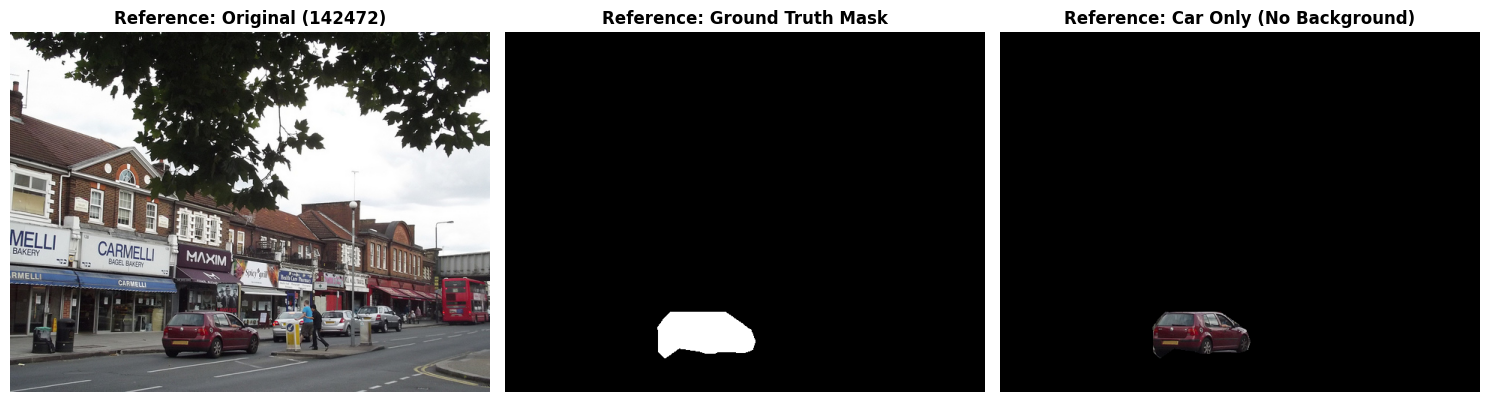

✓ Reference created from image 142472


In [22]:
# Create REFERENCE image from first car (142472)
ref_img_original = Image.open(ref_img_path).convert('RGB')

# Apply ground truth mask
ref_img_array = np.array(ref_img_original)
ref_mask_3d = np.stack([ref_gt_mask] * 3, axis=2)

# Keep actual colors, remove background (black)
reference_array = ref_img_array * ref_mask_3d
reference_img = Image.fromarray(reference_array.astype(np.uint8))

# Save reference
os.makedirs('reference', exist_ok=True)
reference_img.save('reference/car_ref_142472.png')

# Display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(ref_img_original)
axes[0].set_title('Reference: Original (142472)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(ref_gt_mask, cmap='gray')
axes[1].set_title('Reference: Ground Truth Mask', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(reference_img)
axes[2].set_title('Reference: Car Only (No Background)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Reference created from image 142472")


In [23]:
# Extract DINOv2 features from REFERENCE image
ref_tensor = t_dinov2(reference_img).unsqueeze(0).to(_target_device)
ref_global_feature = extract_global_feature(model, ref_tensor, _target_device)

print("✓ Reference features extracted")
print(f"  Feature shape: {ref_global_feature.shape}")
print(f"  Feature norm: {torch.norm(ref_global_feature).item():.4f}")


✓ Reference features extracted
  Feature shape: torch.Size([1, 384])
  Feature norm: 25.6855


TEST WITHOUT BACKGROUND REMOVAL
Reference: 142472 | Test: 369812


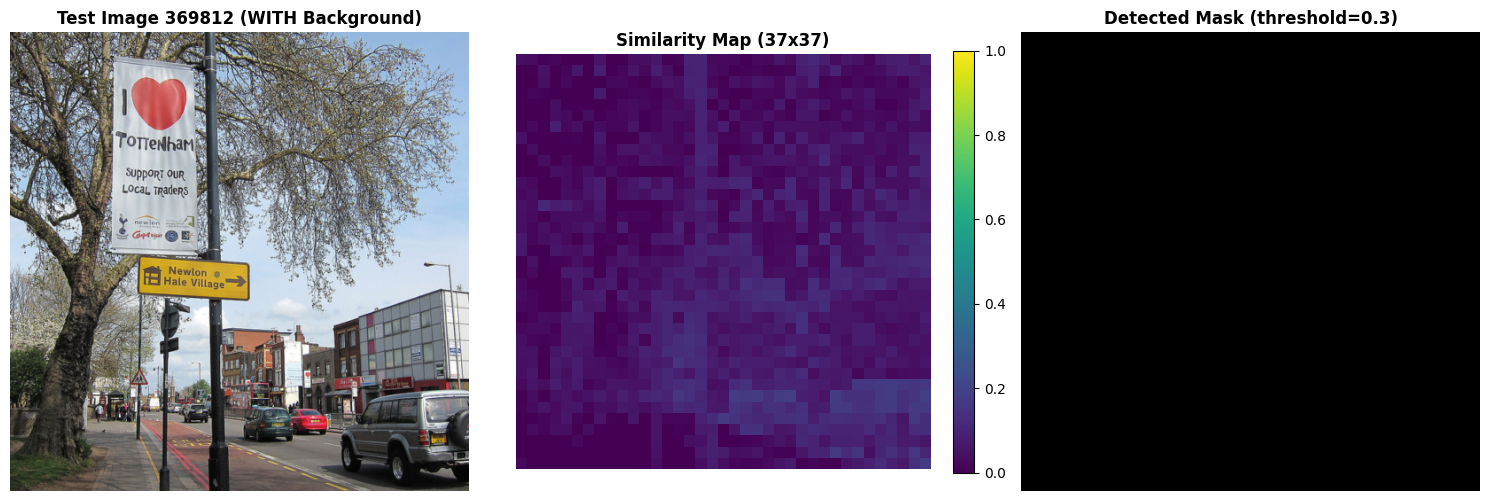

Detection coverage: 0.0% of image


In [24]:
# TEST 1: WITHOUT Background Removal
print("="*70)
print("TEST WITHOUT BACKGROUND REMOVAL")
print("="*70)
print("Reference: 142472 | Test: 369812")
print("="*70)

# Load TEST image (different car)
test_img_original = Image.open(test_img_path).convert('RGB')

# Extract features from test image (with background)
test_tensor = t_dinov2(test_img_original).unsqueeze(0).to(_target_device)
test_patch_features = extract_patch_features(model, test_tensor, _target_device)

# Compute similarity map
similarity_map_without = compute_similarity_map(ref_global_feature, test_patch_features)

# Threshold and upscale
threshold = 0.3
binary_mask_without = (similarity_map_without >= threshold).astype(np.float32)
upscaled_mask_without = upscale_mask(binary_mask_without, target_size=(518, 518))

# Resize for visualization
test_img_resized = test_img_original.resize((518, 518), Image.BILINEAR)

# Display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_img_resized)
axes[0].set_title('Test Image 369812 (WITH Background)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(similarity_map_without, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title('Similarity Map (37x37)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046)

axes[2].imshow(upscaled_mask_without, cmap='gray', vmin=0, vmax=1)
axes[2].set_title(f'Detected Mask (threshold={threshold})', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Detection coverage: {upscaled_mask_without.mean()*100:.1f}% of image")


TEST WITH BACKGROUND REMOVAL
Reference: 142472 | Test: 369812 (background removed)


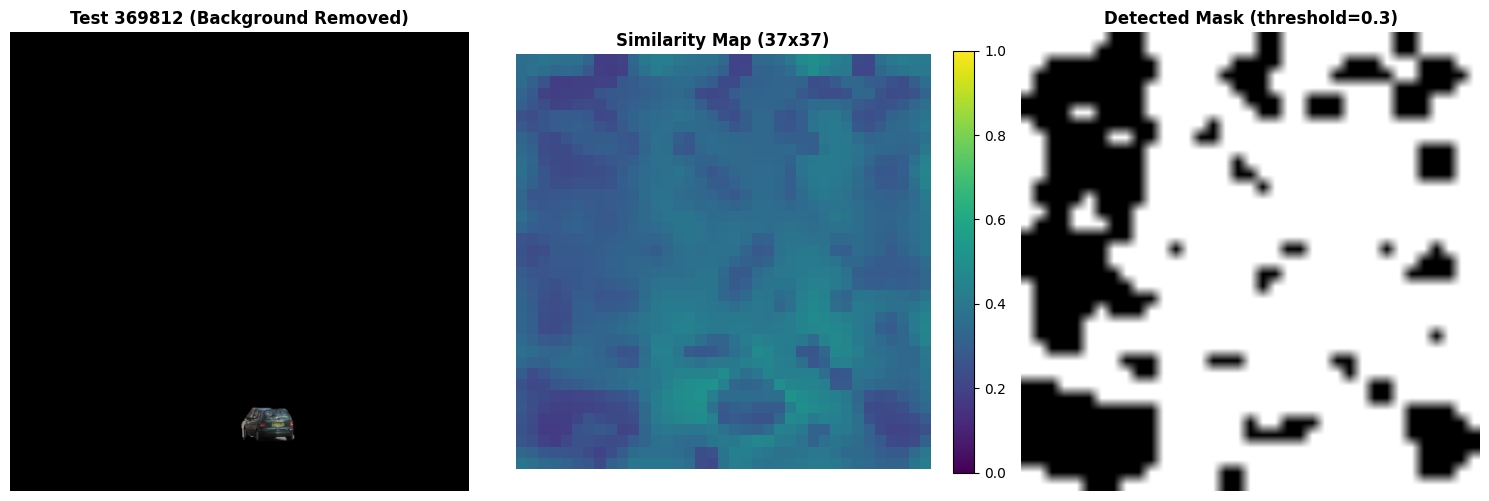

Detection coverage: 70.3% of image


In [25]:
# TEST 2: WITH Background Removal
print("="*70)
print("TEST WITH BACKGROUND REMOVAL")
print("="*70)
print("Reference: 142472 | Test: 369812 (background removed)")
print("="*70)

# Remove background from test image using ground truth
test_img_cleaned = apply_mask(test_img_original, test_gt_mask, background_color=(0, 0, 0))

# Extract features from CLEANED test image
test_cleaned_tensor = t_dinov2(test_img_cleaned).unsqueeze(0).to(_target_device)
test_cleaned_patch_features = extract_patch_features(model, test_cleaned_tensor, _target_device)

# Compute similarity map
similarity_map_with = compute_similarity_map(ref_global_feature, test_cleaned_patch_features)

# Threshold and upscale
binary_mask_with = (similarity_map_with >= threshold).astype(np.float32)
upscaled_mask_with = upscale_mask(binary_mask_with, target_size=(518, 518))

# Resize for visualization
test_img_cleaned_resized = test_img_cleaned.resize((518, 518), Image.BILINEAR)

# Display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_img_cleaned_resized)
axes[0].set_title('Test 369812 (Background Removed)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(similarity_map_with, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title('Similarity Map (37x37)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046)

axes[2].imshow(upscaled_mask_with, cmap='gray', vmin=0, vmax=1)
axes[2].set_title(f'Detected Mask (threshold={threshold})', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Detection coverage: {upscaled_mask_with.mean()*100:.1f}% of image")


COMPARISON


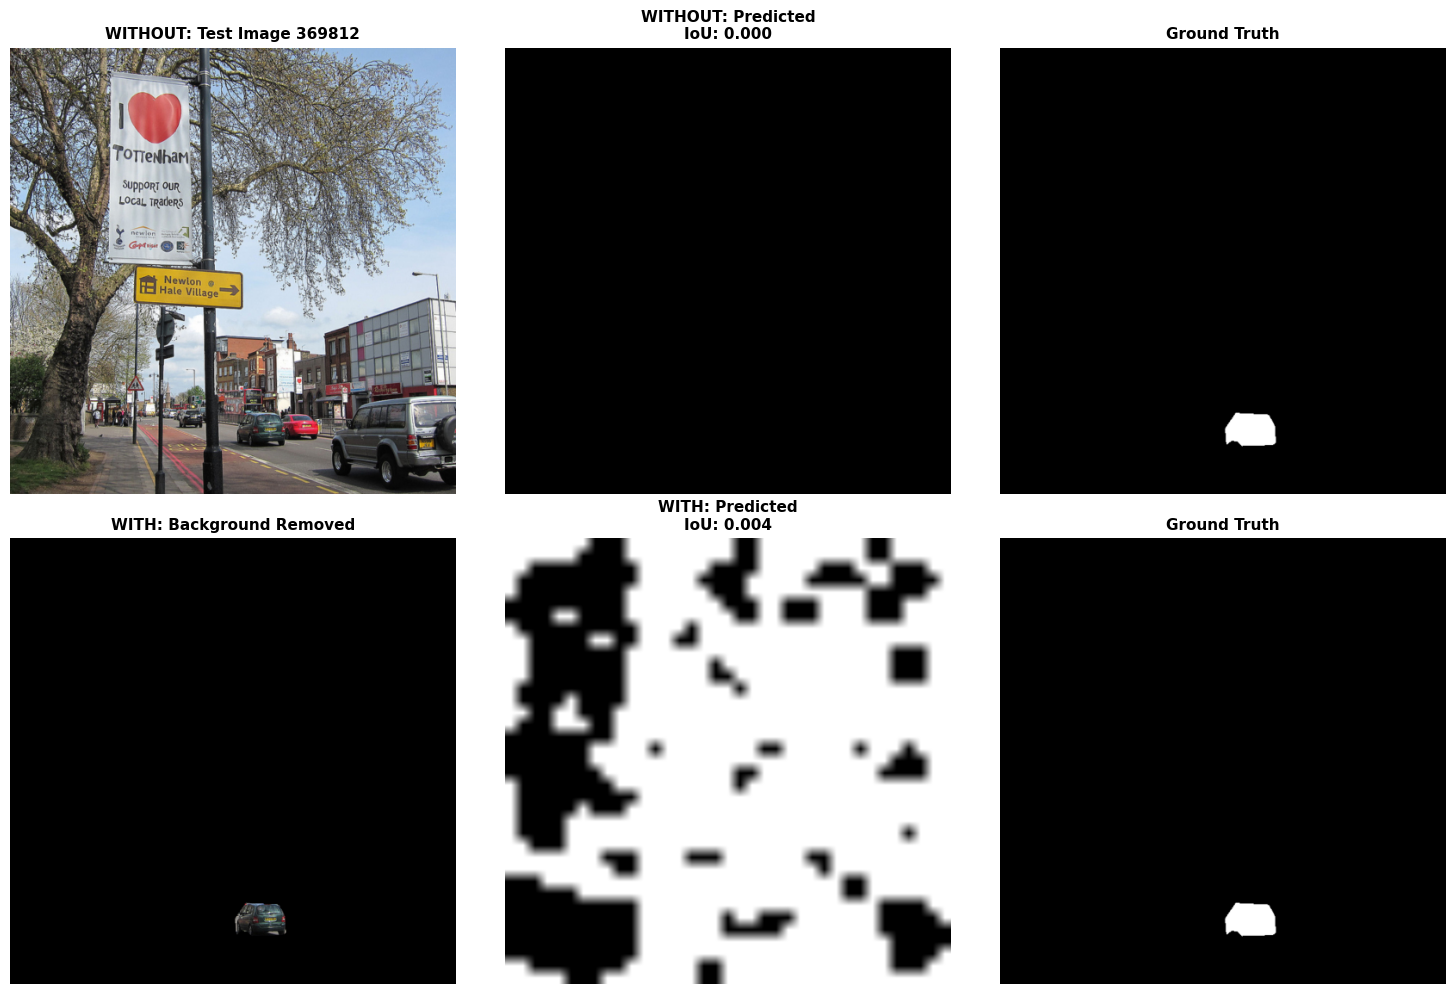


Results:
  Reference: Image 142472 (car with no background)
  Test: Image 369812 (different car)
  WITHOUT background removal: IoU = 0.000
  WITH background removal:    IoU = 0.004

✓ Background removal IMPROVES detection!


In [26]:
# COMPARISON: WITHOUT vs WITH Background Removal
print("="*70)
print("COMPARISON")
print("="*70)

# Compute IoU with ground truth of TEST image
test_gt_mask_resized = np.array(Image.fromarray((test_gt_mask * 255).astype(np.uint8)).resize(
    (518, 518), Image.BILINEAR)) / 255.0

def compute_iou(pred, gt):
    pred_binary = (pred > 0.5).astype(int)
    gt_binary = (gt > 0.5).astype(int)
    intersection = np.sum(pred_binary & gt_binary)
    union = np.sum(pred_binary | gt_binary)
    return intersection / union if union > 0 else 0

iou_without = compute_iou(upscaled_mask_without, test_gt_mask_resized)
iou_with = compute_iou(upscaled_mask_with, test_gt_mask_resized)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: WITHOUT
axes[0, 0].imshow(test_img_resized)
axes[0, 0].set_title('WITHOUT: Test Image 369812', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(upscaled_mask_without, cmap='gray')
axes[0, 1].set_title(f'WITHOUT: Predicted\nIoU: {iou_without:.3f}', fontsize=11, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(test_gt_mask_resized, cmap='gray')
axes[0, 2].set_title('Ground Truth', fontsize=11, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: WITH
axes[1, 0].imshow(test_img_cleaned_resized)
axes[1, 0].set_title('WITH: Background Removed', fontsize=11, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(upscaled_mask_with, cmap='gray')
axes[1, 1].set_title(f'WITH: Predicted\nIoU: {iou_with:.3f}', fontsize=11, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(test_gt_mask_resized, cmap='gray')
axes[1, 2].set_title('Ground Truth', fontsize=11, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"\nResults:")
print(f"  Reference: Image 142472 (car with no background)")
print(f"  Test: Image 369812 (different car)")
print(f"  WITHOUT background removal: IoU = {iou_without:.3f}")
print(f"  WITH background removal:    IoU = {iou_with:.3f}")
if iou_without > 0:
    improvement = ((iou_with - iou_without) / iou_without * 100)
    print(f"  Improvement: {improvement:+.1f}%")

if iou_with > iou_without:
    print("\n✓ Background removal IMPROVES detection!")
else:
    print("\n✗ Background removal does NOT improve detection")
